## Loading dependencies and data

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr

# Load the dataset
data = pd.read_csv('everything_merged_dataset_no_NULL_violent&sexual.csv')

## Visualize data
Some visualization of data before analyses

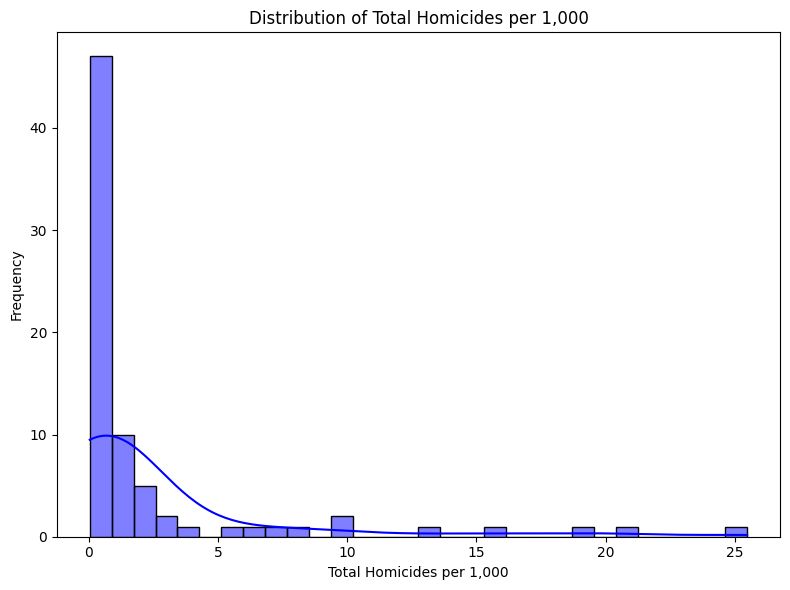

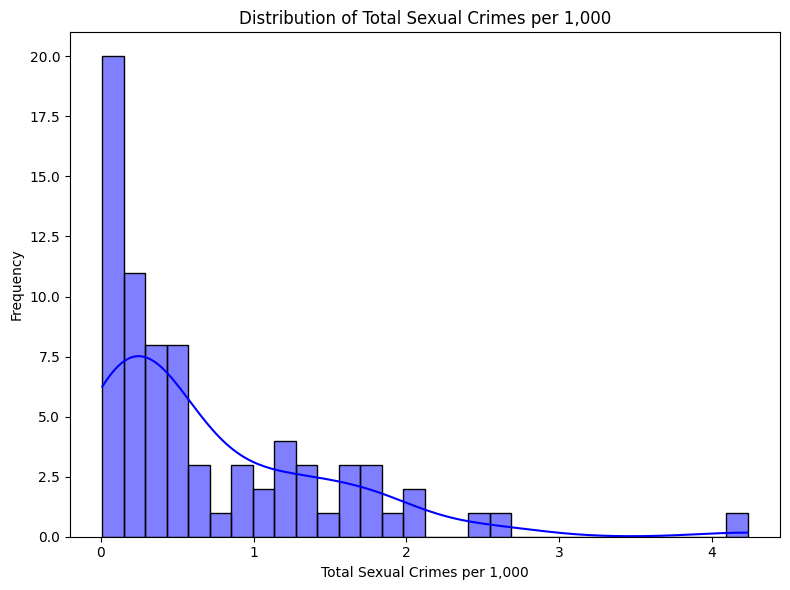

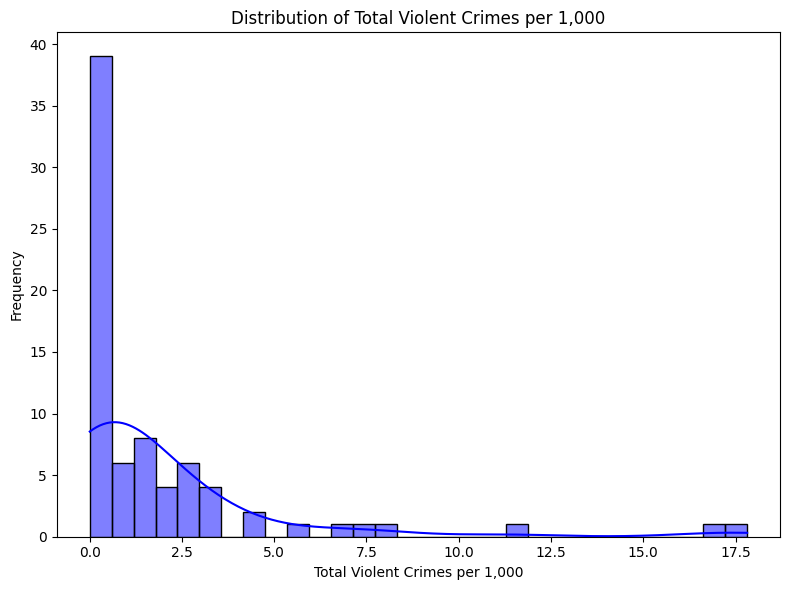

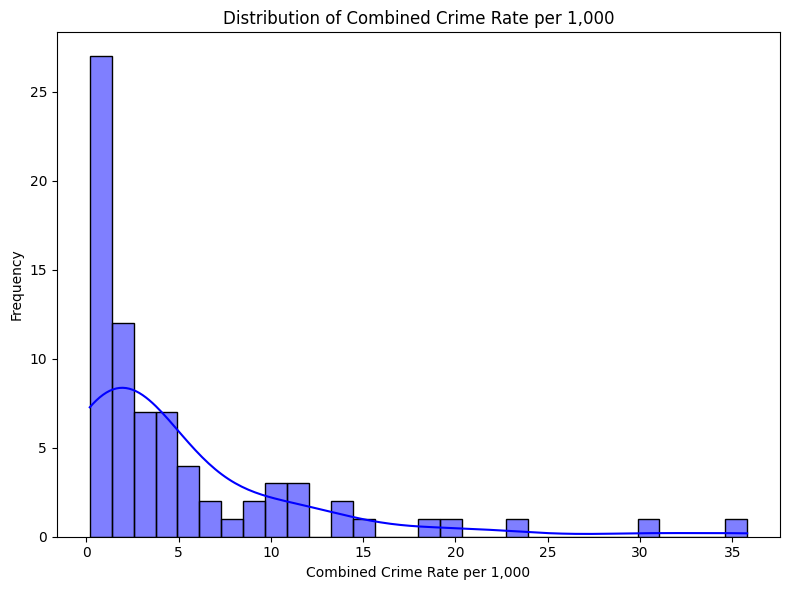

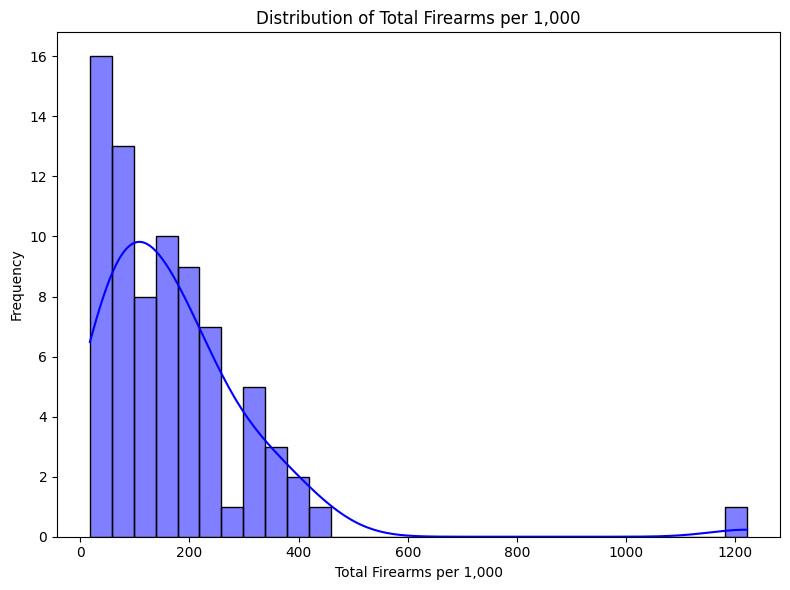

In [171]:
# We use the columns with the per 1000 data
columns_per_1000 = [
    "Total Homicides per 1,000",
    "Total Sexual Crimes per 1,000",
    "Total Violent Crimes per 1,000",
    "Combined Crime Rate per 1,000",
    "Total Firearms per 1,000"
]

# And now we create histograms to visualize distribution of data
for column in columns_per_1000:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], bins=30, kde=True, color='blue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

<Figure size 2500x2000 with 0 Axes>

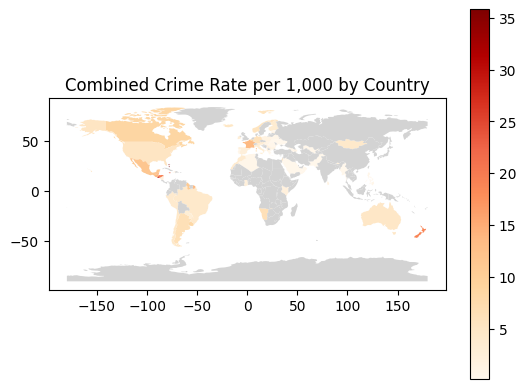

<Figure size 2500x2000 with 0 Axes>

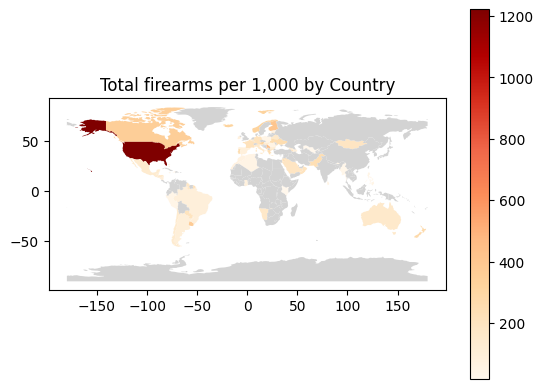

In [172]:
# Create world maps
file_path = "geo/ne_110m_admin_0_countries.shx" # world map data
world = gpd.read_file(file_path)
world = world.rename(columns={"NAME": "Country"})

# Merge data with world map
map_data = world.merge(data, on="Country", how="left")

# Plot Combined Crime Rate per 1,000
plt.figure(figsize=(25, 20))
map_data.plot(
    column="Combined Crime Rate per 1,000",
    cmap="OrRd",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
plt.title("Combined Crime Rate per 1,000 by Country")
plt.show()

# Plot Total firearms per 1,000 by Country
plt.figure(figsize=(25, 20))
map_data.plot(
    column="Total Firearms per 1,000",
    cmap="OrRd",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
plt.title("Total firearms per 1,000 by Country")
plt.show()

## Analyses of RQs
This is a start I guess

1. What is the general relationship between total sum of weapons for each type of crime seperated and also all types of crime combined  
2. group countries with similar gun stats together and check how their distributions compare  
3. check if GDP could be a confounding variable (AKA, check relationship between GDP and crime stats)  
4. Check if the presence of weapons in civilian hands changes stuff (check whether that could be a confounding variable too)  

As for question 2:
- 3 that contain the % of type of firearm possesion
- one that contains the distribution
- column "firearm group" which is a way to group countries together that have a similar distribution, basically each country gets assigned a group number

I printed the data so you guys can see  
It's not done yet but we can work with it maybe

Correlations between weapons and crime types:
{'Total Homicides per 1,000': -0.03792166872967035, 'Total Sexual Crimes per 1,000': 0.13552659215031007, 'Total Violent Crimes per 1,000': 0.10587926076517708, 'Combined Crime Rate per 1,000': 0.03938638828219129}


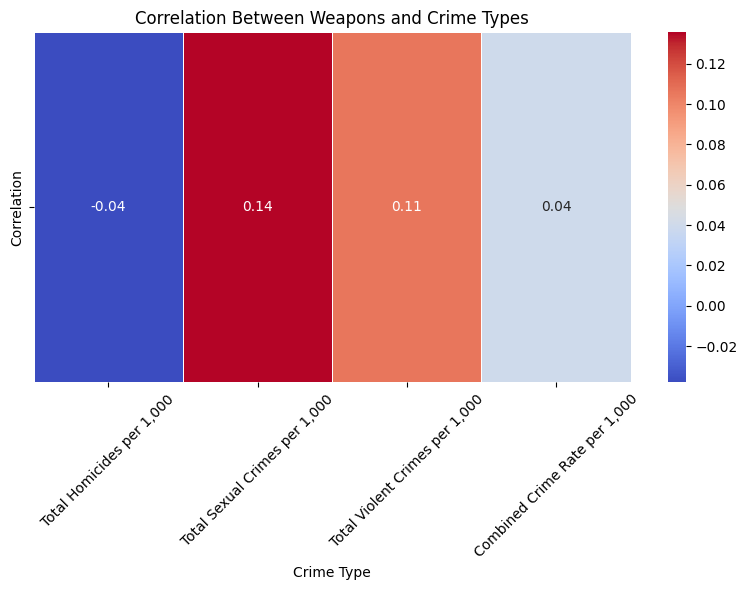

In [173]:
# General Relationship Between Weapons and Crime Types
crime_columns = ["Total Homicides per 1,000", "Total Sexual Crimes per 1,000", "Total Violent Crimes per 1,000", "Combined Crime Rate per 1,000"]
weapon_column = "Total Firearms per 1,000"

# Correlations between weapons and crime types
correlations = {}
for crime in crime_columns:
    correlation, _ = pearsonr(data[weapon_column], data[crime])
    correlations[crime] = correlation

print("Correlations between weapons and crime types:")
print(correlations)

# Create heatmap
correlation_df = pd.DataFrame(list(correlations.items()), columns=["Crime Type", "Correlation"])
plt.figure(figsize=(8, 6))  
sns.heatmap(
    correlation_df.set_index("Crime Type").T,
    annot=True,
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    fmt=".2f"
)
plt.title("Correlation Between Weapons and Crime Types")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [174]:
# Create columns for firearm distribution per 1,000
data["Civilian Firearms %"] = (
    data["Estimate of firearms in civilian possession per 1,000"] /
    data["Total Firearms per 1,000"]
) * 100
data["Military Firearms %"] = (
    data["Total military firearms per 1,000"] /
    data["Total Firearms per 1,000"]
) * 100
data["Law Enforcement Firearms %"] = (
    data["Total law enforcement firearms per 1,000"] /
    data["Total Firearms per 1,000"]
) * 100

# Combine into a new column as a distribution
data["Firearm Distribution"] = data.apply(
    lambda row: (
        row["Civilian Firearms %"],
        row["Military Firearms %"],
        row["Law Enforcement Firearms %"]
    ),
    axis=1
)

data.head()

# Function to group countries with a 10% margin
def find_similar_groups(data, margin=10):
    similar_groups = []
    visited = set()

    for i, dist1 in enumerate(data["Firearm Distribution"]):
        if i in visited:
            continue

        group = [i]
        for j, dist2 in enumerate(data["Firearm Distribution"]):
            if j != i and j not in visited:
                # Check if the distribution is within the margin
                if all(
                    abs((a - b) / a * 100) <= margin
                    for a, b in zip(dist1, dist2)
                    if a != 0
                ):
                    group.append(j)

        visited.update(group)
        similar_groups.append(group)

    return similar_groups

# Find groups
# Okay so the distribution differs a lot between countries which results in lots of groups
groups = find_similar_groups(data, margin=30) # try playing with the margin
print(groups)                                 # it's really hard to get good groups

# Assign groups to countries
data["Firearm Group"] = None
for group_id, group in enumerate(groups):
    for idx in group:
        data.loc[idx, "Firearm Group"] = group_id


grouped_countries = data[["Country", "Firearm Group", "Civilian Firearms %", "Military Firearms %", "Law Enforcement Firearms %"]]
grouped_countries.sort_values("Firearm Group").head()



[[0, 11, 16, 24, 40], [1, 22, 70], [2, 66], [3, 25], [4], [5, 29, 41, 53, 73], [6], [7, 36], [8, 38], [9], [10, 69], [12, 63], [13], [14, 57], [15], [17], [18], [19], [20, 52, 56], [21, 39, 58], [23], [26, 44, 47], [27], [28, 45, 67], [30, 32], [31], [33, 64], [34], [35], [37, 42, 75], [43, 50], [46], [48], [49], [51], [54], [55, 60], [59], [61], [62], [65], [68], [71], [72], [74]]


,Country,Firearm Group,Civilian Firearms %,Military Firearms %,Law Enforcement Firearms %
0,Albania,0,89.571337,5.566219,4.862444
16,Brazil,0,89.203385,6.705792,4.090823
24,France,0,92.291433,4.105925,3.602642
11,Belgium,0,90.130941,5.023977,4.845082
40,Kenya,0,88.514688,5.404117,6.081195


Correlations between GDP and crime types:
{'Total Homicides per 1,000': -0.049770658267863345, 'Total Sexual Crimes per 1,000': -0.01136170526158686, 'Total Violent Crimes per 1,000': 0.08836990758036015, 'Combined Crime Rate per 1,000': 0.005265788687624857}


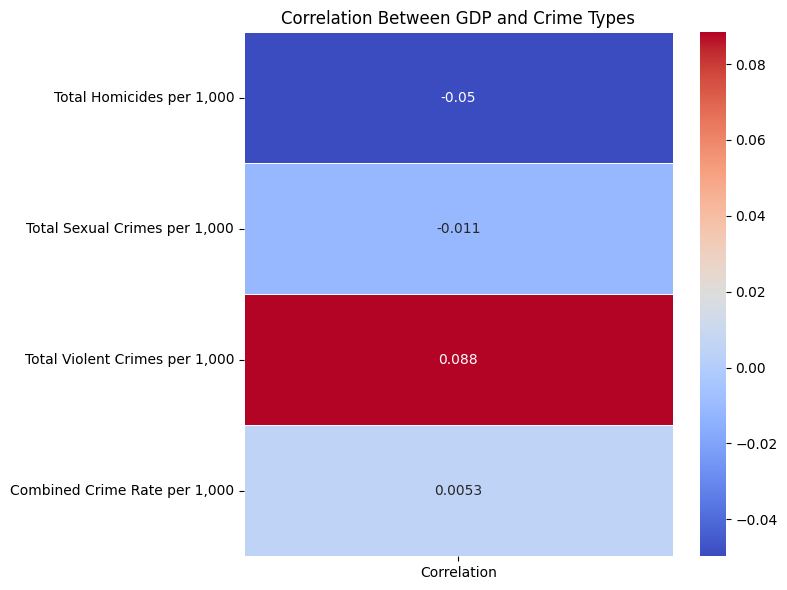

In [175]:
# GDP as a Confounding Variable
gdp_column = "Country GDP"

# Correlations between GDP and crime stats
gdp_crime_correlations = {}
for crime in crime_columns:
    correlation, _ = pearsonr(data[gdp_column], data[crime])
    gdp_crime_correlations[crime] = correlation

print("Correlations between GDP and crime types:")
print(gdp_crime_correlations)

# Create heatmap
correlation_df = pd.DataFrame.from_dict(gdp_crime_correlations, orient='index', columns=['Correlation'])
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_df,
    annot=True,
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation Between GDP and Crime Types")
plt.tight_layout()
plt.show()

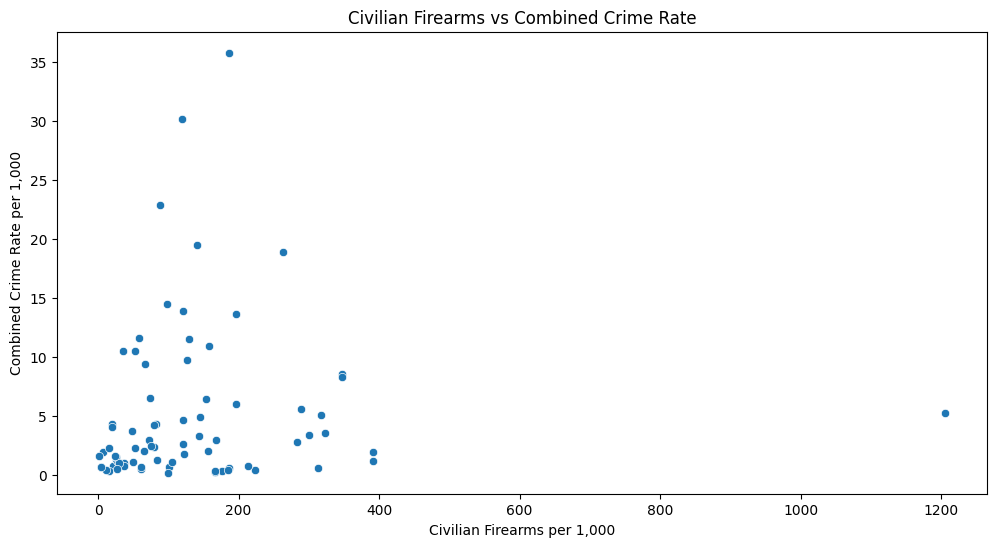

Correlation between civilian firearms and combined crime rate: 0.08879425288446355


In [176]:
# Impact of Civilian Gun Ownership
# Relationship between civilian firearms per 1,000 and crime rates
civ_gun_column = "Estimate of firearms in civilian possession per 1,000"

plt.figure(figsize=(12, 6))
sns.scatterplot(x=civ_gun_column, y='Combined Crime Rate per 1,000', data=data)
plt.title('Civilian Firearms vs Combined Crime Rate')
plt.xlabel('Civilian Firearms per 1,000')
plt.ylabel('Combined Crime Rate per 1,000')
plt.show()

# Correlation
civ_gun_correlation, _ = pearsonr(data[civ_gun_column], data['Combined Crime Rate per 1,000'])
print(f"Correlation between civilian firearms and combined crime rate: {civ_gun_correlation}")